In this notebook, I implemented a B-spline, a Generalized additive model (GAM) with B-splines, and a single layer KAN from scratch. I then applied them to toy datasets. My reasoning for building a GAM was to confirm somethign that my mentor and I suspected, which is that it is equivalent to a single-layer KAN (which is confirmed by the results in this notebook).

In [42]:
import torch
import torch.functional as F
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
class BSpline(torch.nn.Module):
    def __init__(self, num_knots=10, degree=3):
        """Initialize a B-Spline

        Args:
            num_knots (int, optional): number of knots in B-spline. Defaults to 10.
            degree (int, optional): degree of polynomials. Defaults to 3.
        """
        super(BSpline, self).__init__()
        # should the knots be learnable?
        self.num_knots = num_knots

        self.degree = degree

        # initialize knots 
        self.knots = torch.cat([torch.zeros(3), torch.linspace(0, 1, num_knots - 6), torch.ones(3)])
        # put knots on the endpoints so they don't always evaluate to 0

        # learnable coefficients for each basis function
        num_coeficents = num_knots - 1 - degree
        self.coefficients = torch.nn.Parameter(torch.randn(num_coeficents))

    def basis_function(self, i, k, x):
        """Recursively perform linear interpolation to compute the B-spline basis function

        Args:
            i (int): index of the knot
            k (int): degree of the polynomial
            x (torch.Tensor): input value

        Returns:
            torch.Tensor: value of the basis function at x
        """
        if k == 0:
            # at base case, return 1 if x is in the interval [knots[i], knots[i + 1]) and 0 otherwise
            return ((x >= self.knots[i]) & (x < self.knots[i + 1])).float()
        else:
            # don't divide by zero...
            denominator_1 = self.knots[i + k] - self.knots[i]
            denominator_2 = self.knots[i + k + 1] - self.knots[i + 1]

            term_1 = 0 if denominator_1 == 0 else ((x - self.knots[i]) / denominator_1) * self.basis_function(i, k - 1, x)

            term_2 = 0 if denominator_2 == 0 else ((self.knots[i + k + 1] - x) / denominator_2) * self.basis_function(i + 1, k - 1, x)
            return term_1 + term_2

    def forward(self, x):
        """Forward pass of the B-spline"""
        n = len(self.coefficients)
        result = torch.zeros_like(x, dtype=torch.float32)
        for i in range(n):
            result += self.coefficients[i] * self.basis_function(i, self.degree, x)

        return result


degree = number of knots - number of control points (coefficients) - 1
number of coefficients = number of knots - degree - 1

In [44]:
# toy dataset
x = torch.linspace(0, 0.9999, 1000) # .9999 because the B-spline is defined on [0, 1) so it just evaluates to 0 at x = 1
y = torch.sin(x*5)

In [45]:
spline = BSpline(num_knots=10, degree=3)

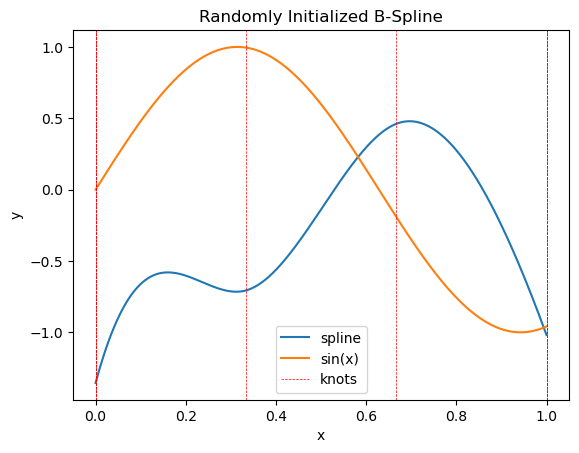

In [46]:
# plot the randomly initialized spline
spline_out = spline(x).detach()

plt.plot(x, spline_out)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Randomly Initialized B-Spline")

# insert verticle lines at the knots
for knot in spline.knots:
    plt.axvline(knot, color='r', linestyle='--', linewidth=0.5)

plt.legend(["spline", "sin(x)", 'knots'])

In [47]:
# fit spline to data
num_itrs = 1_000
lr = 0.01
optimizer = torch.optim.Adam(spline.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    spline_out = spline(x)
    loss = torch.nn.functional.mse_loss(spline_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 1.2100839614868164
iteration 50, loss: 0.6218242049217224
iteration 100, loss: 0.30914801359176636
iteration 150, loss: 0.15407007932662964
iteration 200, loss: 0.08279868960380554
iteration 250, loss: 0.050885651260614395
iteration 300, loss: 0.03595910593867302
iteration 350, loss: 0.028192130848765373
iteration 400, loss: 0.023433007299900055
iteration 450, loss: 0.019953710958361626
iteration 500, loss: 0.017073342576622963
iteration 550, loss: 0.014549304731190205
iteration 600, loss: 0.012304503470659256
iteration 650, loss: 0.010314584709703922
iteration 700, loss: 0.008567243814468384
iteration 750, loss: 0.007049983367323875
iteration 800, loss: 0.005747565999627113
iteration 850, loss: 0.00464229378849268
iteration 900, loss: 0.0037148837000131607
iteration 950, loss: 0.002945407759398222


Text(0.5, 1.0, 'Mean Squared Error (MSE) Loss of B-Spline Over 1000 Training Iterations')

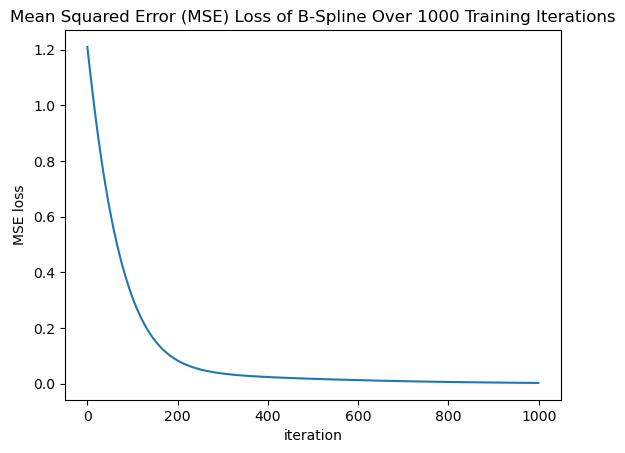

In [48]:
# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')
plt.title(f'Mean Squared Error (MSE) Loss of B-Spline Over {num_itrs} Training Iterations')

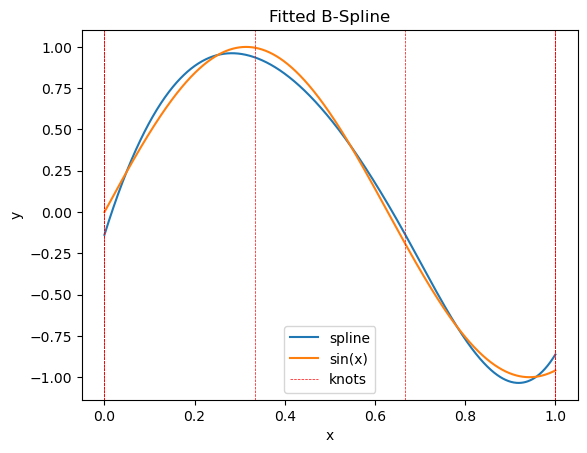

In [49]:
# plot the fitted spline
spline_out = spline(x).detach()

plt.plot(x, spline_out)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted B-Spline")

# insert verticle lines at the knots
for knot in spline.knots:
    plt.axvline(knot, color='r', linestyle='--', linewidth=0.5)

plt.legend(["spline", "sin(x)", 'knots'])

# GAM on Toy Dataset

In [50]:
# make toy dataset. in theory this could be modeled with a 1-layer KAN or a GAM with splines
num_samples = 100

transformations = [torch.sin, torch.log, lambda x: x**2]

num_features = len(transformations)

X = torch.rand(num_samples, num_features)

bias = torch.normal(mean=0, std=0.1, size=(1,))

# apply transformations to each feature and sum to get y
y = torch.sum(torch.stack([t(5 * X[:, i]) for i, t in enumerate(transformations)], dim=1), dim=1) + bias

# make sure no nan values
assert not torch.isnan(y).any()

X.shape, y.shape

(torch.Size([100, 3]), torch.Size([100]))

In [51]:
class GAM(torch.nn.Module):
    def __init__(self, num_features, num_knots=10, degree=3):
        """Initialize a Generalized Additive Model (GAM) with B-splines

        Args:
            num_features (int): number of features in the input
            num_knots (int, optional): number of knots in each B-spline. Defaults to 15.
            degree (int, optional): degree of the polynomial. Defaults to 3.
        """
        super(GAM, self).__init__()
        self.splines = [BSpline(num_knots=num_knots, degree=degree) for i in range(num_features)]

        self.bias = torch.nn.Parameter(torch.randn(1))

        # a little hacky; just so B-spline parameters are recognized by pytorch and learned
        self.parameters = nn.ParameterList([spline.coefficients for spline in self.splines])

    def forward(self, X):
        """Forward pass of the GAM"""
        return torch.sum(torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1), dim=1) + self.bias

In [52]:
gam = GAM(num_features=num_features)

In [53]:
# fit GAM to data
num_itrs = 5_000
lr = 0.01
optimizer = torch.optim.Adam(gam.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    gam_out = gam(X)
    loss = torch.nn.functional.mse_loss(gam_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 158.1492919921875
iteration 50, loss: 121.48839569091797
iteration 100, loss: 94.6936264038086
iteration 150, loss: 75.57962036132812
iteration 200, loss: 61.82463073730469
iteration 250, loss: 51.73418045043945
iteration 300, loss: 44.139183044433594
iteration 350, loss: 38.23358917236328
iteration 400, loss: 33.48057174682617
iteration 450, loss: 29.53653335571289
iteration 500, loss: 26.184152603149414
iteration 550, loss: 23.28384780883789
iteration 600, loss: 20.74303436279297
iteration 650, loss: 18.4976749420166
iteration 700, loss: 16.501493453979492
iteration 750, loss: 14.719548225402832
iteration 800, loss: 13.124462127685547
iteration 850, loss: 11.694106101989746
iteration 900, loss: 10.410151481628418
iteration 950, loss: 9.257131576538086
iteration 1000, loss: 8.221787452697754
iteration 1050, loss: 7.2925920486450195
iteration 1100, loss: 6.459420204162598
iteration 1150, loss: 5.713271617889404
iteration 1200, loss: 5.046069145202637
iteration 1250, 

Text(0.5, 1.0, 'Mean Squared Error (MSE) Loss of GAM Over 5000 Training Iterations')

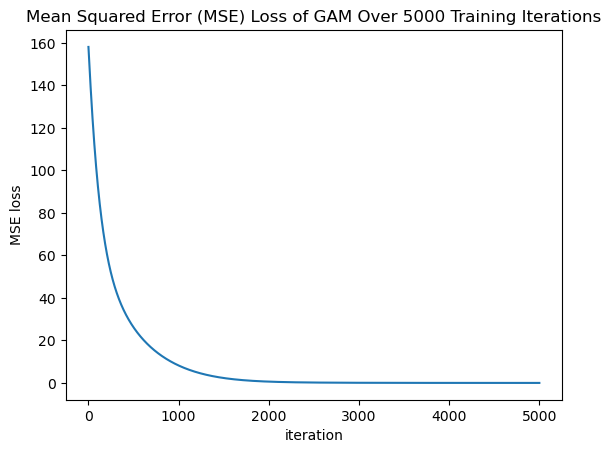

In [54]:
# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')
plt.title(f'Mean Squared Error (MSE) Loss of GAM Over {num_itrs} Training Iterations')

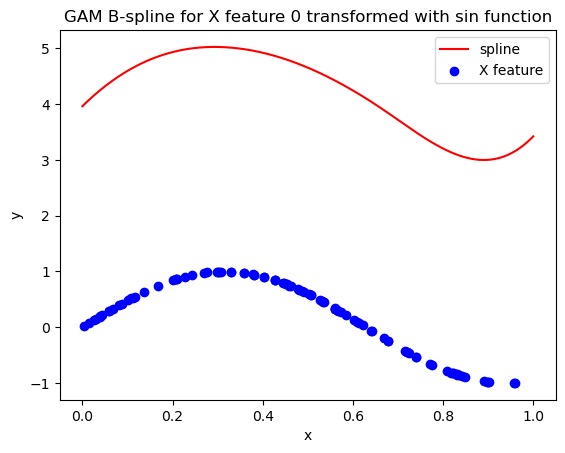

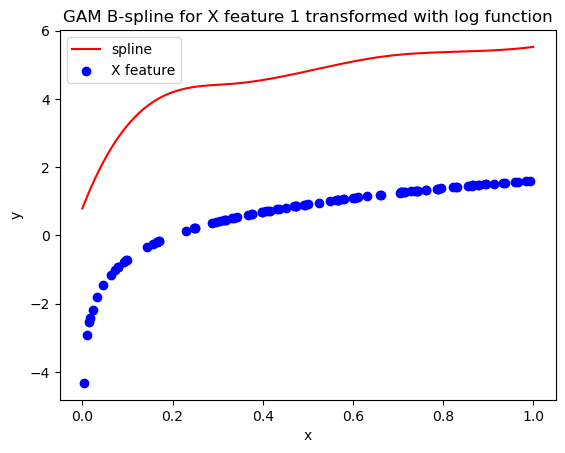

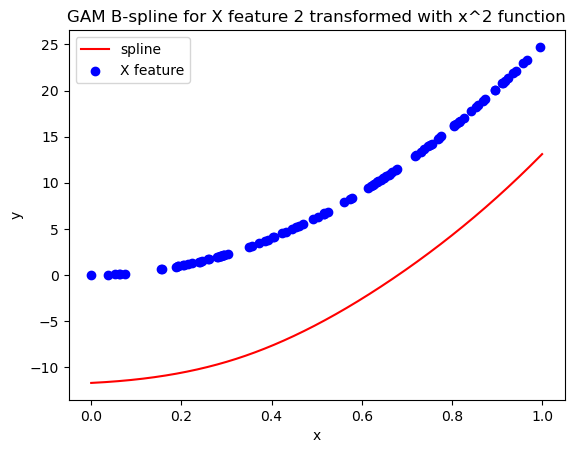

In [55]:
# plot splines

dummy_x = torch.linspace(0, 0.9999, 1000) # .9999 because the B-spline is defined on [0, 1) so it just evaluates to 0 at x = 1

transformation_names = ['sin', 'log', 'x^2']

for i, (spline, transformation) in enumerate(zip(gam.splines, transformations)):
    plt.plot(dummy_x, spline(dummy_x).detach(), c='r')
    
    x = X[:, i]
    plt.scatter(x, transformation(5 * x), c='b')
    plt.legend(["spline", "X feature"])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"GAM B-spline for X feature {i} transformed with {transformation_names[i]} function")

    plt.show()

# One Layer KAN

It seems like the only difference between a one-layer KAN and a B-spline based GAM is how the activations are implemented.

In a GAM each function of the features in just a B-spline which is evaluated, summed, and added to a bias term to get a final output

In a one-layer KAN, instead of simply a b-spline, we have:

$$
\phi(x) = w_b \cdot b(x) + w_s \cdot \text{spline}(x)
$$

for each feature.

Where b(x) is a basis function. In the paper, they just use a SiLU activation function for it and claim the reasoning for using it is the same as the reasoning for residual blocks; helps to reduce loss of input signal

Finally, wb and ws are learnable parameters that control the relative importance of each function and its associated feature. The authors explain that these two parameters are technically reduntant since they can be 'absorbed' into the spline and the basis but are nonetheless included to control the magnitude of the activation function. 



In [56]:
class OneLayerKAN(torch.nn.Module):
    def __init__(self, num_features, num_knots=10, degree=3, basis_function='silu'):
        """Initialize a one-layer Kolmogorov-Arnold Network (KAN)

        Args:
            num_features (int): number of features in the input
            num_knots (int, optional): number of knots in each B-spline. Defaults to 10.
            degree (int, optional): degree of the B-spline polynomials. Defaults to 3.
            basis_function (str, optional): basis function for each activation function. Defaults to 'silu'.
        """
        super(OneLayerKAN, self).__init__()
        # not bothering to initialize the way they do it in the paper
        self.splines = [BSpline(num_knots=num_knots, degree=degree) for i in range(num_features)]

        self.basis_function = getattr(torch.nn.functional, basis_function)
        
        self.parameters = nn.ParameterList([spline.coefficients for spline in self.splines])

        self.basis_coefficients = torch.nn.Parameter(torch.randn(num_features))
        self.spline_coefficients = torch.nn.Parameter(torch.randn(num_features))

    def forward(self, X):
        """Forward pass of the one-layer KAN"""
        # ϕ(x) = wb * b(x) + ws * spline(x)
        spline_output = torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1)
        spline_output_weighted = spline_output @ self.spline_coefficients

        basis_output = self.basis_function(X)
        basis_output_weighted = basis_output @ self.basis_coefficients
        
        # ϕ(x) = wb * b(x) + ws * spline(x)
        return basis_output_weighted + spline_output_weighted
    
    def get_activations(self, X):
        """
        Get the raw activations of the KAN without the final sum
        Useful for interpretability...
        """
        # obtain raw activations (basis + spline outputs) without final sum
        spline_output = torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1)
        spline_output_weighted = spline_output * self.spline_coefficients

        basis_output = self.basis_function(X)
        basis_output_weighted = basis_output * self.basis_coefficients
        
        return basis_output_weighted + spline_output_weighted    

In [57]:
kan = OneLayerKAN(num_features=num_features)

In [58]:
# fit KAN to data
num_itrs = 5_000
lr = 0.01
optimizer = torch.optim.Adam(kan.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    kan_out = kan(X)
    loss = torch.nn.functional.mse_loss(kan_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 164.4945068359375
iteration 50, loss: 120.61294555664062
iteration 100, loss: 74.62397766113281
iteration 150, loss: 40.695579528808594
iteration 200, loss: 23.34039306640625
iteration 250, loss: 13.086450576782227
iteration 300, loss: 7.3070969581604
iteration 350, loss: 4.40846061706543
iteration 400, loss: 2.8915348052978516
iteration 450, loss: 2.03450608253479
iteration 500, loss: 1.5349783897399902
iteration 550, loss: 1.24034583568573
iteration 600, loss: 1.0617738962173462
iteration 650, loss: 0.9470018148422241
iteration 700, loss: 0.8669615387916565
iteration 750, loss: 0.8063807487487793
iteration 800, loss: 0.7574024200439453
iteration 850, loss: 0.7158305644989014
iteration 900, loss: 0.6792013049125671
iteration 950, loss: 0.6458837985992432
iteration 1000, loss: 0.6146878004074097
iteration 1050, loss: 0.5846896171569824
iteration 1100, loss: 0.555151104927063
iteration 1150, loss: 0.5254778861999512
iteration 1200, loss: 0.49519971013069153
iteration 

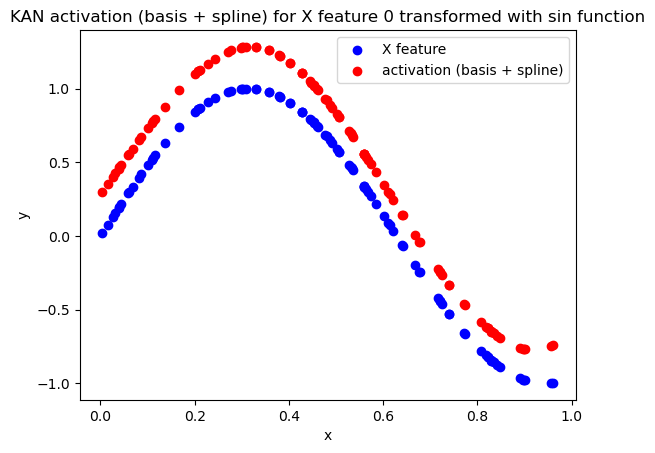

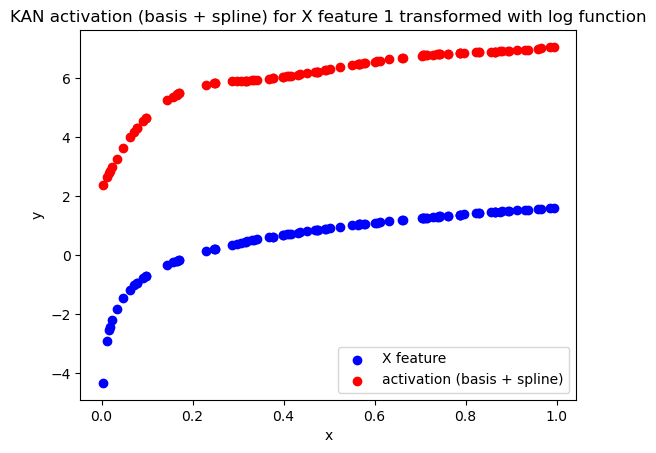

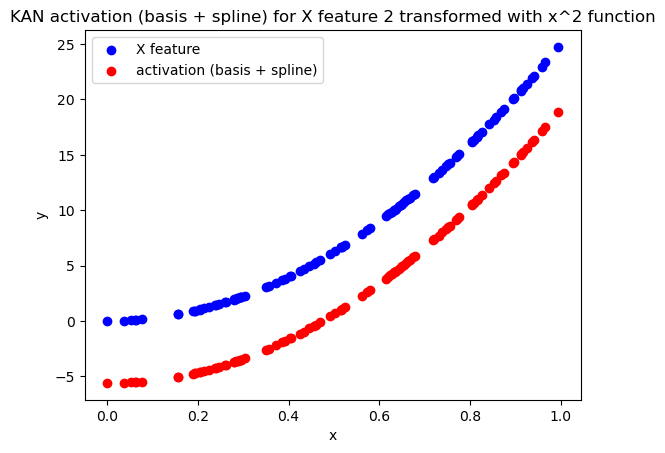

In [59]:
# plot kan activations
activations = kan.get_activations(X).detach().numpy()

transformation_names = ['sin', 'log', 'x^2']

for i, (feature_activation, transformation) in enumerate(zip(activations.T, transformations)):
    plt.scatter(X[:, i], transformation(5 * X[:, i]), c='b')
    plt.scatter(X[:, i], feature_activation, c='r')
    plt.legend(["X feature", "activation (basis + spline)"])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"KAN activation (basis + spline) for X feature {i} transformed with {transformation_names[i]} function")

    plt.show()
